In [14]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections
import datetime

1. Работа с метриками: логарифмирование и удаление выбросов
2. Ранговая трансформация
3. CUPED
4. Линеаризация ratio-метрик
5. Стратификация

In [15]:
df = pd.read_csv('./data/2019-Dec.csv')
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554
3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4
4,2019-12-01 00:00:07 UTC,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5


In [16]:
shop_metrics_new = pd.read_csv('./data/shop_df_metrics_dec.csv').drop(columns='Unnamed: 0')
shop_metrics_old = pd.read_csv('./data/shop_df_metrics_sept.csv').drop(columns='Unnamed: 0')
shop_users_info = pd.read_csv('./data/shop_df_users.csv').drop(columns='Unnamed: 0')

In [17]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode # кодирует байтоподобный объект с помощью Base64 и возвращает закодированную байтовую строку.
    salt = os.urandom(8)

    return b64encode(salt).decode('ascii')

# '''os.urandom() method is used to generate a string of size random bytes suitable for cryptographic use
#    or we can say this method generates a string containing random characters.'''
# https://www.geeksforgeeks.org/python-os-urandom-method/

In [18]:
def groups_splitter(df, user_salt=None):
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())
    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[['user_id', 'group']].drop_duplicates()

# Работаем с агрегированным датафреймом

Датафрейм создан на базе https://www.kaggle.com/datasets/mkechinov/ecommerce-events-history-in-electronics-store - данные по действиям пользователей в онлайн-магазине электроники

In [19]:
shop_metrics_new = pd.read_csv('./data/shop_df_metrics_dec.csv').drop(columns='Unnamed: 0')
shop_metrics_old = pd.read_csv('./data/shop_df_metrics_sept.csv').drop(columns='Unnamed: 0')
shop_users_info = pd.read_csv('./data/shop_df_users.csv').drop(columns='Unnamed: 0')
shop_users_info.dtypes

user_id      int64
user_age     int64
user_sex    object
dtype: object

In [20]:
shop_metrics_new.head(5)

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0


In [21]:
shop_metrics_old.head(5)

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
0,1515915625353226922,B,1,1,76.48,0.0,0.0,0,0
1,1515915625353230067,A,1,1,28.98,0.0,0.0,0,0
2,1515915625353230683,A,1,10,592.21,0.0,0.0,0,0
3,1515915625353230922,A,1,1,274.40,0.0,0.0,0,0
4,1515915625353234047,A,1,14,1857.94,0.0,0.0,0,0


Метрики:
   - is_viewed - айтем товара просмотрен
   - products_viewed_cnt - количество уникальных просмотренных айтемов
   - price_sum - суммарная цена товаров
   - is_cart_added - товар добавлен в корзину
   - is_purchased - товар куплен
   - cart_added_cnt - количество товаров, добавленных в корзину
   - purchased_cnt - количество купленных товаров

<Axes: xlabel='cart_added_cnt', ylabel='Count'>

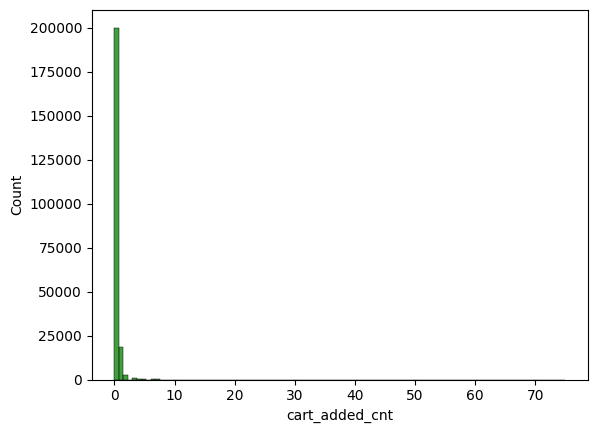

In [22]:
sns.histplot(data=shop_metrics_new, x='cart_added_cnt', bins=100, color='green')

<Axes: xlabel='is_cart_added', ylabel='Count'>

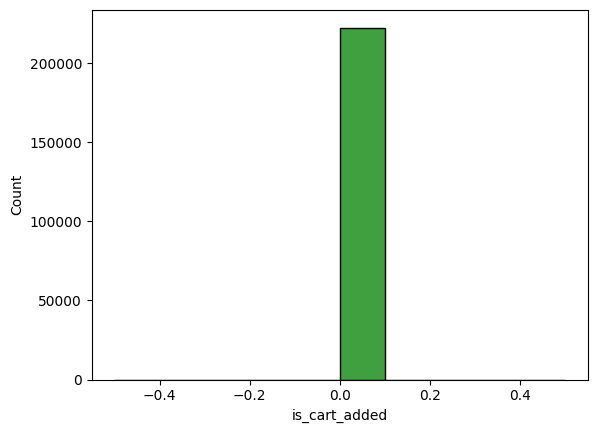

In [23]:
sns.histplot(data=shop_metrics_new, x='is_cart_added', bins=10, color='green')

<Axes: xlabel='purchased_cnt', ylabel='Count'>

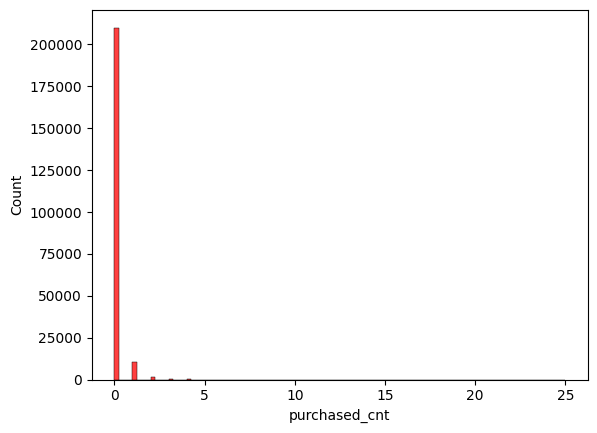

In [24]:
sns.histplot(data=shop_metrics_new, x='purchased_cnt', bins=100, color='red')

# Посмотрим на вектор метрики purchased_cnt

In [25]:
shop_metrics_new.groupby('group')['purchased_cnt'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,111321.0,0.068576,0.340553,0.0,0.0,0.0,0.0,25.0
B,111200.0,0.069281,0.348589,0.0,0.0,0.0,0.0,21.0


In [26]:
np.percentile(shop_metrics_new['purchased_cnt'], 99.9)

np.float64(3.0)

In [27]:
shop_metrics_new[shop_metrics_new['purchased_cnt'] > 3].count()

user_id                207
group                  207
is_viewed              207
products_viewed_cnt    207
price_sum              207
is_cart_added          207
is_purchased           207
cart_added_cnt         207
purchased_cnt          207
dtype: int64

# Прологарифмируем

In [28]:
shop_metrics_new['purchased_cnt_ln'] = np.log(shop_metrics_new['purchased_cnt'] + 1)

<Axes: xlabel='purchased_cnt_ln', ylabel='Count'>

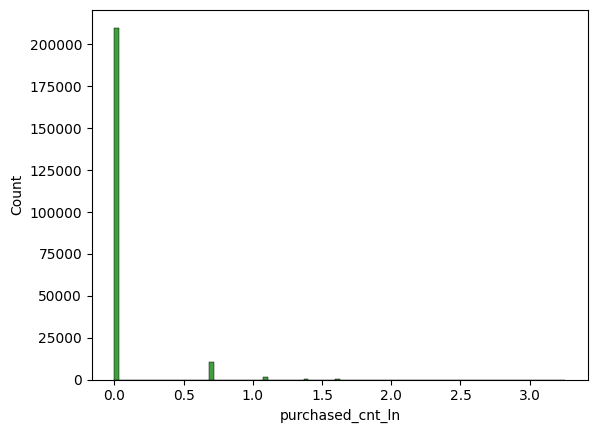

In [29]:
sns.histplot(data=shop_metrics_new, x='purchased_cnt_ln', bins=100, color='green')

Проверим мощность и корректность t-критерия

In [30]:
shop = shop_metrics_new.drop(columns=['group'])
shop['purchased_cnt'].std()

np.float64(0.34459161610329514)

100%|██████████| 100/100 [00:30<00:00,  3.26it/s]

0.02701997629105026
 power: 59.0% , correctness: 94.0%


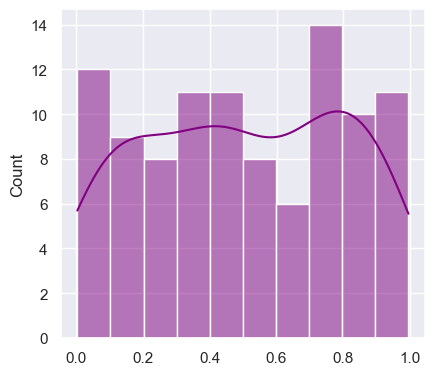

In [31]:
# мощность и корректность t-test для исходной метрики
correctness = []
power = []

for i in tqdm(range(100)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    vec_a = new_df[(new_df['group'] == 'A')]['purchased_cnt']
    vec_b = new_df[(new_df['group'] == 'B')]['purchased_cnt']
    vec_b_effect = vec_b + stats.norm.rvs(loc=vec_b.mean() * 0.05, scale=0.35, size=len(vec_b))
    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='purple', kde=True)

power = np.array(power)
print((vec_b_effect.mean() - vec_a.mean())/vec_a.mean())
print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

Для этого примера будем накладывать эффект домножением на константу, потому что нормальное распределение нам не подходит из-за появления отрицательных значений

При их логарифмировании возникнет ошибка RuntimeWarning: invalid value encountered in log в использовании функции np.log

100%|██████████| 100/100 [00:30<00:00,  3.32it/s]

 power: 60.0% , correctness: 96.0%


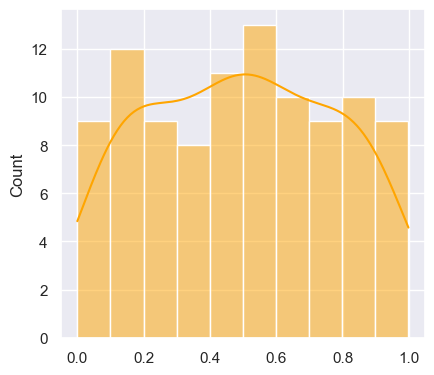

In [32]:
correctness = []
power = []

# 100 итераций - мало, так не делаем, пример иллюстративный
for i in tqdm(range(100)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    vec_a = new_df[(new_df['group'] == 'A')]['purchased_cnt']
    vec_b = new_df[(new_df['group'] == 'B')]['purchased_cnt']
    vec_b_effect = vec_b * 1.05
    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='orange', kde=True)

power = np.array(power)
print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

А теперь проверим на прологарифмированной метрике

100%|██████████| 100/100 [00:30<00:00,  3.25it/s]

 power: 39.0% , correctness: 96.0%


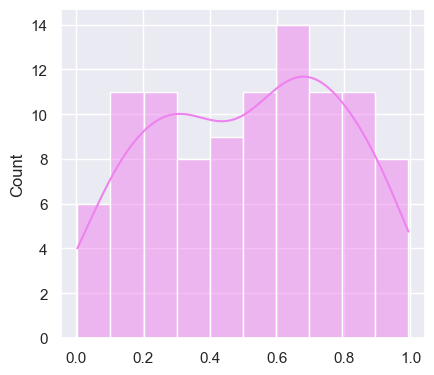

In [33]:
# мощность и корректность
correctness = []
power = []

for i in tqdm(range(100)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    vec_a = new_df[(new_df['group'] == 'A')]['purchased_cnt']
    vec_b = new_df[(new_df['group'] == 'B')]['purchased_cnt']
    vec_b_effect = vec_b * 1.05

    vec_a_ln = np.log(vec_a + 1)
    vec_b_ln = np.log(vec_b + 1)
    vec_b_effect_ln = np.log(vec_b_effect + 1) # сначала добавили эффект, а потом логарифмируем!

    p_cor, p_power = stats.ttest_ind(vec_a_ln, vec_b_ln)[1], stats.ttest_ind(vec_a_ln, vec_b_effect_ln)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='violet', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

Вывод: мощность упала + стало сложно трактовать результаты с точки зрения эффекта

# Удаление выбросов

Попробуем удалить выбросы по стандартному отклонению и по 99 перцентилю:

In [34]:
# посчитаем параметры и вычислим "край" метрики для подхода "3 стандартных отклонения"
print(f" metric mean: {shop_metrics_new['purchased_cnt'].mean()}, \
         metric std: {shop_metrics_new['purchased_cnt'].std()}, \
         metric edge: {(shop_metrics_new['purchased_cnt'].mean() + 3 * shop_metrics_new['purchased_cnt'].std())}")

 metric mean: 0.06892832586587333,          metric std: 0.34459161610329514,          metric edge: 1.1027031741757587


In [35]:
np.percentile(shop_metrics_new['purchased_cnt'], 99)

np.float64(1.0)

In [36]:
shop_metrics_new[shop_metrics_new['purchased_cnt'] > 1].count()

user_id                1826
group                  1826
is_viewed              1826
products_viewed_cnt    1826
price_sum              1826
is_cart_added          1826
is_purchased           1826
cart_added_cnt         1826
purchased_cnt          1826
purchased_cnt_ln       1826
dtype: int64

Снова проверим мощность и корректность на том же эффекте в 5%

100%|██████████| 1000/1000 [05:09<00:00,  3.23it/s]

 power: 100.0% , correctness: 95.0%


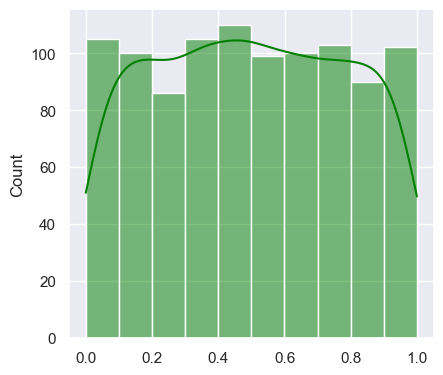

In [75]:
# для выбросов в 3 стандартных отклонения
correctness = []
power = []

for i in tqdm(range(1000)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    metric_edge = new_df['purchased_cnt'].mean() + 3*new_df['purchased_cnt'].std()

    vec_a = new_df[(new_df['group'] == 'A')]['purchased_cnt']
    vec_b = new_df[(new_df['group'] == 'B')]['purchased_cnt']
    vec_b_effect = vec_b + stats.norm.rvs(loc=vec_b.mean() * 0.05, scale=0.35, size=len(vec_b))

    vec_a_reduced = vec_a[vec_a <= metric_edge]
    vec_b_reduced = vec_b[vec_b <= metric_edge]
    vec_b_effect_reduced = vec_b_effect[vec_b_effect <= metric_edge]

    p_cor, p_power = stats.ttest_ind(vec_a_reduced, vec_b_reduced)[1], stats.ttest_ind(vec_a_reduced, vec_b_effect_reduced)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='green', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

100%|██████████| 100/100 [00:31<00:00,  3.21it/s]

 power: 100.0% , correctness: 99.0%


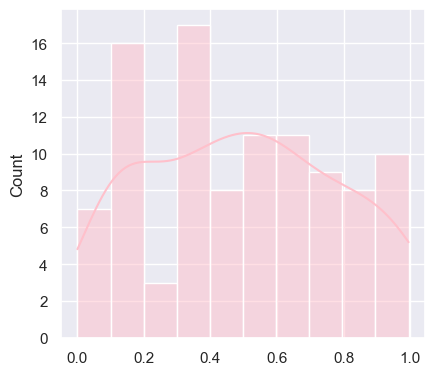

In [38]:
# для выбросов в > 99 перцентиля
correctness = []
power = []

for i in tqdm(range(100)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    metric_edge = np.percentile(new_df['purchased_cnt'], 99)

    vec_a = new_df[(new_df['group'] == 'A')]['purchased_cnt']
    vec_b = new_df[(new_df['group'] == 'B')]['purchased_cnt']
    vec_b_effect = vec_b + stats.norm.rvs(loc=vec_b.mean() * 0.05, scale=0.35, size=len(vec_b))

    vec_a_reduced = vec_a[vec_a <= metric_edge]
    vec_b_reduced = vec_b[vec_b <= metric_edge]
    vec_b_effect_reduced = vec_b_effect[vec_b_effect <= metric_edge]

    p_cor, p_power = stats.ttest_ind(vec_a_reduced, vec_b_reduced)[1], stats.ttest_ind(vec_a_reduced, vec_b_effect_reduced)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='pink', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

А теперь посмотрим, что было бы, если эффект накладывали иначе:

100%|██████████| 100/100 [00:31<00:00,  3.16it/s]

 power: 72.0% , correctness: 97.0%


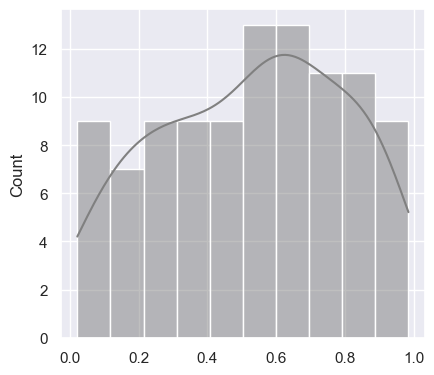

In [39]:
# для выбросов в 3 стандартных отклонения
correctness = []
power = []

for i in tqdm(range(100)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    metric_edge = new_df['purchased_cnt'].mean() + 3*new_df['purchased_cnt'].std()

    vec_a = new_df[(new_df['group'] == 'A')]['purchased_cnt']
    vec_b = new_df[(new_df['group'] == 'B')]['purchased_cnt']
    vec_b_effect = vec_b * 1.05

    vec_a_reduced = vec_a[vec_a <= metric_edge]
    vec_b_reduced = vec_b[vec_b <= metric_edge]
    vec_b_effect_reduced = vec_b_effect[vec_b_effect <= metric_edge]

    p_cor, p_power = stats.ttest_ind(vec_a_reduced, vec_b_reduced)[1], stats.ttest_ind(vec_a_reduced, vec_b_effect_reduced)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='grey', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

100%|██████████| 100/100 [00:31<00:00,  3.20it/s]

 power: 100.0% , correctness: 96.0%


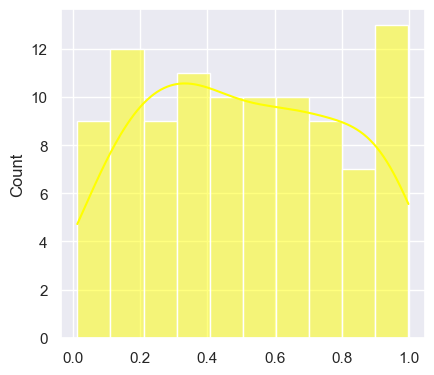

In [40]:
# для выбросов в > 99 перцентиля
correctness = []
power = []

for i in tqdm(range(100)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    metric_edge = np.percentile(new_df['purchased_cnt'], 99)

    vec_a = new_df[(new_df['group'] == 'A')]['purchased_cnt']
    vec_b = new_df[(new_df['group'] == 'B')]['purchased_cnt']
    vec_b_effect = vec_b * 1.05

    vec_a_reduced = vec_a[vec_a <= metric_edge]
    vec_b_reduced = vec_b[vec_b <= metric_edge]
    vec_b_effect_reduced = vec_b_effect[vec_b_effect <= metric_edge]

    p_cor, p_power = stats.ttest_ind(vec_a_reduced, vec_b_reduced)[1], stats.ttest_ind(vec_a_reduced, vec_b_effect_reduced)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='yellow', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

Вывод: удаление выбросов может увеличить мощность за счет сокращения дисперсии, но если модель/фича действительно повлияла на активных юзеров с большим количеством покупок (эффект распределен неравномерно), то мы можем их удалить случайно

# Ранговая трансформация

In [41]:
def rank_transformation(df_a, df_b, metric):
    df = pd.concat([df_a, df_b], axis = 0)
    df['rank'] = df[metric].rank()
    return df

Опробуем функцию на существующем датафрейме на той же метрике

In [42]:
ranked = rank_transformation(shop_metrics_new[shop_metrics_new.group == 'A'],
                             shop_metrics_new[shop_metrics_new.group == 'B'], 'purchased_cnt')

ranked

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,purchased_cnt_ln,rank
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0.0,105026.0
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0.0,105026.0
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0.0,105026.0
5,1515915625353400724,A,1,2,103.33,0.0,0.0,0,0,0.0,105026.0
7,1515915625353416040,A,1,13,1861.21,0.0,0.0,0,0,0.0,105026.0
...,...,...,...,...,...,...,...,...,...,...,...
222516,1515915625611023671,B,1,1,32.22,0.0,0.0,0,0,0.0,105026.0
222517,1515915625611023730,B,1,1,219.94,0.0,0.0,0,0,0.0,105026.0
222518,1515915625611024014,B,1,1,80.03,0.0,0.0,0,0,0.0,105026.0
222519,1515915625611024020,B,1,1,64.92,0.0,0.0,0,0,0.0,105026.0


In [80]:
print(ranked['rank'].unique(), len(ranked['rank'].unique()))

[105026.  215373.5 222169.5 221360.  222373.5 222448.  222497.5 222514.
 222473.  222521.  222511.5 222488.  222506.  222519.  222502.5 222515.5
 222517.  222509. ] 18


In [43]:
ranked[ranked['purchased_cnt'] > 0]

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,purchased_cnt_ln,rank
108,1515915625367976920,A,1,4,144.83,0.0,0.0,1,1,0.693147,215373.5
142,1515915625377197718,A,1,4,630.57,0.0,0.0,3,3,1.386294,222169.5
157,1515915625382330267,A,1,3,331.89,0.0,0.0,2,2,1.098612,221360.0
184,1515915625392941295,A,1,1,20.00,0.0,0.0,1,1,0.693147,215373.5
185,1515915625393382317,A,1,8,1655.00,0.0,0.0,3,3,1.386294,222169.5
...,...,...,...,...,...,...,...,...,...,...,...
222191,1515915625610977027,B,1,1,80.56,0.0,0.0,1,1,0.693147,215373.5
222248,1515915625610986148,B,1,1,292.83,0.0,0.0,1,1,0.693147,215373.5
222277,1515915625610991774,B,1,1,298.76,0.0,0.0,1,1,0.693147,215373.5
222314,1515915625610995356,B,1,1,29.40,0.0,0.0,1,1,0.693147,215373.5


In [44]:
print(ranked[ranked.group == 'A']['rank'].mean(),
      ranked[ranked.group == 'B']['rank'].mean(),
      ((ranked[ranked.group == 'B']['rank'].mean() - ranked[ranked.group == 'A']['rank'].mean()) /
       ranked[ranked.group == 'A']['rank'].mean()*100))

111259.8768022206 111262.12441996404 0.0020201512063729755


In [45]:
stats.ttest_ind(ranked[ranked.group == 'A']['rank'], ranked[ranked.group == 'B']['rank'])

TtestResult(statistic=np.float64(-0.020711883610533208), pvalue=np.float64(0.9834755078743136), df=np.float64(222519.0))

Различий между группами не было => t-test не нашел разницу

Средние изменились достаточно сильно (по сравнению с исходными), разница между группами ~0.2%

Для сравнения t-test на той же метрике, но без ранговой трансформации:

In [46]:
stats.ttest_ind(shop_metrics_new[shop_metrics_new.group == 'A']['purchased_cnt'],
                shop_metrics_new[shop_metrics_new.group == 'B']['purchased_cnt'])

TtestResult(statistic=np.float64(-0.4819416819988476), pvalue=np.float64(0.6298478488694023), df=np.float64(222519.0))

Cредние тоже практически идентичны, но разница между группами выше

In [47]:
print(shop_metrics_new[shop_metrics_new.group == 'A']['purchased_cnt'].mean(),
      shop_metrics_new[shop_metrics_new.group == 'B']['purchased_cnt'].mean(),
     ((shop_metrics_new[shop_metrics_new.group == 'B']['purchased_cnt'].mean() - shop_metrics_new[shop_metrics_new.group == 'A']['purchased_cnt'].mean())/shop_metrics_new[shop_metrics_new.group == 'A']['purchased_cnt'].mean()*100))

0.068576459068819 0.06928057553956835 1.0267611951832336


Сравним с результатом применения критерия Манна-Уитни:

In [48]:
stats.mannwhitneyu(shop_metrics_new[shop_metrics_new.group == 'A']['purchased_cnt'],
                   shop_metrics_new[shop_metrics_new.group == 'B']['purchased_cnt'])

MannwhitneyuResult(statistic=np.float64(6189322564.5), pvalue=np.float64(0.9834755182644684))

Проверим мощность и корректность t-test для метода ранговой трансформации

100%|██████████| 100/100 [00:39<00:00,  2.53it/s]

 power: 75.0% , correctness: 92.0%


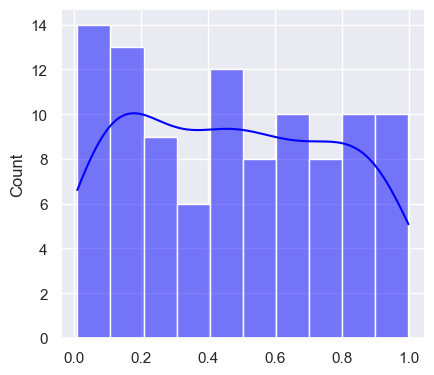

In [49]:
# мощность и корректность для ранговой трансформации
correctness = []
power = []

for i in tqdm(range(100)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    ranked_df = rank_transformation(new_df[new_df.group == 'A'], new_df[new_df.group == 'B'], 'purchased_cnt')

    vec_a = ranked_df[(ranked_df['group'] == 'A')]['rank']
    vec_b = ranked_df[(ranked_df['group'] == 'B')]['rank']

    vec_b_effect = new_df[new_df['group'] == 'B']['purchased_cnt'] * 1.05
    new_df_b = new_df[new_df.group == 'B'].drop(columns=['purchased_cnt'])
    new_df_b['purchased_cnt'] = list(vec_b_effect)

    ranked_df_effect = rank_transformation(new_df[new_df.group == 'A'], new_df_b, 'purchased_cnt')
    vec_a_power = ranked_df_effect[(ranked_df_effect['group'] == 'A')]['rank']
    vec_b_power = ranked_df_effect[(ranked_df_effect['group'] == 'B')]['rank']


    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a_power, vec_b_power)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

Мощность выросла, но не очень сильно (с ~50% до ~67%)

# CUPED

In [50]:
def cuped_transform(df, metrics):

    new_columns = [str(m+'_cuped') for m in metrics]
    df[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df.index)

    df_mini = df.fillna(0)
    for m in metrics:
        covariate_column = str(m+'_covariate')
        cuped_column = str(m+'_cuped')
        mean_covariate = df_mini[covariate_column].mean()

        theta = (df_mini[m].cov(df_mini[covariate_column]))/(df_mini.loc[:,covariate_column].var())
        df_mini[cuped_column] = df_mini[m] - (df_mini[covariate_column] - mean_covariate) * theta

    df.update(df_mini)

    return df.drop_duplicates()


Возьмем исторические значения из датафрейма old

In [51]:
shop_metrics_old.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
0,1515915625353226922,B,1,1,76.48,0.0,0.0,0,0
1,1515915625353230067,A,1,1,28.98,0.0,0.0,0,0
2,1515915625353230683,A,1,10,592.21,0.0,0.0,0,0
3,1515915625353230922,A,1,1,274.40,0.0,0.0,0,0
4,1515915625353234047,A,1,14,1857.94,0.0,0.0,0,0


In [52]:
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[['user_id', 'purchased_cnt']], on=['user_id'], how='left')

In [53]:
shop_metrics_all = shop_metrics_all\
                   .rename(columns={'purchased_cnt_x': 'purchased_cnt', 'purchased_cnt_y': 'purchased_cnt_covariate'})

In [54]:
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['purchased_cnt'])

/var/folders/rf/r9_1j8lj3m72m2lv3v1tp3rh0000gn/T/ipykernel_5368/3236988277.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.06785952 0.06785952 0.06785952 ... 0.06785952 0.06785952 0.06785952]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.update(df_mini)


In [55]:
shop_metrics_all_cuped.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,purchased_cnt_ln,purchased_cnt_covariate,purchased_cnt_cuped
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0.0,0,0.06786
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0.0,0,0.06786
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0.0,0,0.06786
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0,0.0,0,0.06786
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0,0.0,0,0.06786


Проверим, как на измененной метрике покажет себя t-test:

In [56]:
stats.ttest_ind(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['purchased_cnt_cuped'],
                shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['purchased_cnt_cuped'])

TtestResult(statistic=np.float64(-1.3272760435862192), pvalue=np.float64(0.1844187472696315), df=np.float64(222519.0))

In [ ]:

ttest_cuped = stats.ttest_ind(
    shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['purchased_cnt'],
    shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['purchased_cnt']
)

print(f'p-value метрики без: {ttest_cuped[1]}')

p-value метрики с CUPED: 0.6298478488694023


Сравним средние в измененной метрике и дисперсии:

In [57]:
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["purchased_cnt_cuped"].mean()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["purchased_cnt_cuped"].mean()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["purchased_cnt"].mean()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["purchased_cnt"].mean()}')

метрика_cuped A: 0.06873279002556351,         метрика_cuped B: 0.06912407447449859
метрика без cuped A: 0.068576459068819,         метрика без cuped B: 0.06928057553956835


In [58]:
print(f'метрика_cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["purchased_cnt_cuped"].var()}, \
        метрика_cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["purchased_cnt_cuped"].var()}')
print(f'метрика без cuped A: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "A"]["purchased_cnt"].var()}, \
        метрика без cuped B: {shop_metrics_all_cuped[shop_metrics_all_cuped.group == "B"]["purchased_cnt"].var()}')

метрика_cuped A: 0.005196228304118666,         метрика_cuped B: 0.004472867781518941
метрика без cuped A: 0.11597635026472002,         метрика без cuped B: 0.12151424424718894


Все хорошо: средние сохранились, а дисперсии сократились => понимаем, почему снизился p-value

  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/rf/r9_1j8lj3m72m2lv3v1tp3rh0000gn/T/ipykernel_5368/3236988277.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.06785952 0.06785952 0.06785952 ... 0.06785952 0.06785952 0.06785952]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.update(df_mini)
  1%|          | 1/100 [00:00<00:39,  2.52it/s]/var/folders/rf/r9_1j8lj3m72m2lv3v1tp3rh0000gn/T/ipykernel_5368/3236988277.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.06785952 0.06785952 0.06785952 ... 0.06785952 0.06785952 0.06785952]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.update(df_mini)
  2%|▏         | 2/100 [00:00<00:37,  2.61it/s]/var/folders/rf/r9_1j8lj3m72m2lv3v1tp3rh0000gn/T/ipykernel_5368/3236988277.py:15: FutureWarning: Setting 

 power: 100.0% , correctness: 92.0%


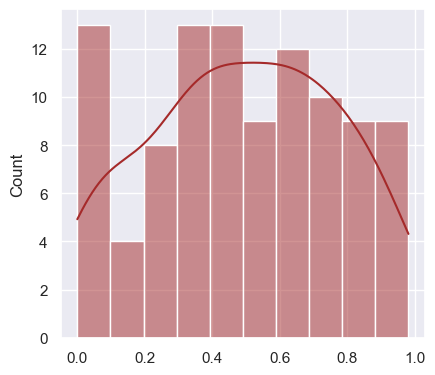

In [59]:
# мощность и корректность для CUPED

correctness = []
power = []

for i in tqdm(range(100)):

    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'purchased_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'purchased_cnt_x': 'purchased_cnt', 'purchased_cnt_y': 'purchased_cnt_covariate'})

    cuped_df = cuped_transform(all_df, ['purchased_cnt'])

    vec_a = cuped_df[(cuped_df['group'] == 'A')]['purchased_cnt_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['purchased_cnt_cuped']

    vec_b_effect = vec_b * 1.05


    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

# Линеаризация ratio-метрик

In [60]:
def linearization(X, Y):

    import numpy as np

    X_mean = np.mean(X)
    Y_mean = np.mean(Y)
    X_Y = X_mean/Y_mean
    z = [ X_Y + (X[i] - X_Y*Y[i])/Y_mean for i in range(len(X))]
    return z


ctr_u = sum(cliked_u) / sum(views_u), CTR = mean(ctr_u),   lin_u = sum(cliked_u) - K_control * sum(views_u), K_control = mean(CTR_control)

In [61]:
def lin_results(df, metric_numerator, metric_denominator):

    new_a = linearization(df[df['group']=='A'][metric_numerator].values, df[df['group']=='A'][metric_denominator].values)
    new_b = linearization(df[df['group']=='B'][metric_numerator].values, df[df['group']=='B'][metric_denominator].values)

    return metric_numerator, metric_denominator, scipy.stats.ttest_ind(new_a, new_b)

Создадим ratio-метрику:

In [62]:
shop_metrics_new['ratio_metric'] = shop_metrics_new['cart_added_cnt'] / shop_metrics_new['products_viewed_cnt']

In [63]:
shop_metrics_new.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,purchased_cnt_ln,ratio_metric
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0.0,0.0
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0.0,0.0
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0.0,0.0
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0,0.0,0.0
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0,0.0,0.0


In [64]:
lin_results(shop_metrics_new, 'cart_added_cnt', 'products_viewed_cnt')

('cart_added_cnt',
 'products_viewed_cnt',
 TtestResult(statistic=np.float64(-1.2024848919197622), pvalue=np.float64(0.22917699567605654), df=np.float64(222519.0)))

Сравним с результатами, полученными "в лоб"

In [65]:
stats.ttest_ind(shop_metrics_new[shop_metrics_new.group == 'A']['ratio_metric'],
                shop_metrics_new[shop_metrics_new.group == 'B']['ratio_metric'])

TtestResult(statistic=np.float64(-1.1548393785270104), pvalue=np.float64(0.2481574481581119), df=np.float64(222519.0))

# Постстратификация

In [85]:
shop_users_info.head()

,user_id,user_age,user_sex
0,1515915625519388267,41,f
1,1515915625519380411,84,m
2,1515915625513238515,41,m
3,1515915625519014356,25,m
4,1515915625510743344,42,m


In [86]:
shop_w_features = pd.merge(shop_metrics_new, shop_users_info, on=['user_id'], how='left')

shop_w_features['age_group'] = shop_w_features['user_age'].mask(shop_w_features['user_age'] < 60, '60minus') \
                               .mask(shop_w_features['user_age'] >= 60, '60plus')
shop_w_features.groupby('group')['age_group'].value_counts()

group  age_group
A      60minus      70034
       60plus       41287
B      60minus      69735
       60plus       41465
Name: count, dtype: int64

Распределение и так довольно равномерное по группам

Вспомним классический результат

In [70]:
stats.ttest_ind(shop_w_features[shop_w_features.group == 'A']['purchased_cnt'],
                shop_w_features[shop_w_features.group == 'B']['purchased_cnt'])

TtestResult(statistic=np.float64(-0.4819416819988476), pvalue=np.float64(0.6298478488694023), df=np.float64(222519.0))

In [71]:
(shop_w_features[shop_w_features.group == 'B']['purchased_cnt'].mean() - shop_w_features[shop_w_features.group == 'A']['purchased_cnt'].mean()) \
        /shop_w_features[shop_w_features.group == 'A']['purchased_cnt'].mean() * 100

np.float64(1.0267611951832336)

In [72]:
print(shop_w_features[shop_w_features.group == 'A']['purchased_cnt'].std(),
      shop_w_features[shop_w_features.group == 'B']['purchased_cnt'].std())

0.3405530065418892 0.3485889330532295


Теперь применим стратификацию и посмотрим, что получится

In [73]:
N = shop_w_features['user_id'].nunique()

strats_weights = {}

for i in range(0, shop_w_features['age_group'].nunique()):
    key = shop_w_features['age_group'].value_counts().index[i]
    strats_weights[key] = shop_w_features['age_group'].value_counts()[i] / N

mean_a = shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['age_group'] == '60minus')]['purchased_cnt'].mean() * strats_weights['60minus']\
        + shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['age_group'] == '60plus')]['purchased_cnt'].mean() * strats_weights['60plus']\

mean_b = shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '60minus')]['purchased_cnt'].mean() * strats_weights['60minus']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '60plus')]['purchased_cnt'].mean() * strats_weights['60plus']

std_a = (shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['age_group'] == '60minus')]['purchased_cnt'].std()**2 * strats_weights['60minus']\
        + shop_w_features[(shop_w_features.group == 'A') & (shop_w_features['age_group'] == '60plus')]['purchased_cnt'].std()**2 * strats_weights['60plus']) # / N
std_b = (shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '60minus')]['purchased_cnt'].std()**2 * strats_weights['60minus']\
        + shop_w_features[(shop_w_features.group == 'B') & (shop_w_features['age_group'] == '60plus')]['purchased_cnt'].std()**2 * strats_weights['60plus']) # / N

n_a = len(shop_w_features[shop_w_features.group == 'A'])
n_b = len(shop_w_features[shop_w_features.group == 'B'])

print(f'effect: {(mean_b - mean_a)/mean_a*100}, std_a: {std_a}, std_b: {std_b}')

stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b, std_b, n_b)

effect: 1.029043278738222, std_a: 0.11596909928203117, std_b: 0.12150240209263265


/var/folders/rf/r9_1j8lj3m72m2lv3v1tp3rh0000gn/T/ipykernel_5368/3253372824.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strats_weights[key] = shop_w_features['age_group'].value_counts()[i] / N
/var/folders/rf/r9_1j8lj3m72m2lv3v1tp3rh0000gn/T/ipykernel_5368/3253372824.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strats_weights[key] = shop_w_features['age_group'].value_counts()[i] / N


Ttest_indResult(statistic=np.float64(-1.4013843118892675), pvalue=np.float64(0.16110057571008288))

In [74]:
strats_weights

{'60minus': np.float64(0.6281159980406343),
 '60plus': np.float64(0.3718840019593656)}